# EP03 da disciplina de Visão e Processamento de Imagens
## (MAC5768/MAC0417 -- 2020)

|Nomes:                        | N° USP:|
|------------------------------|--------|
|Alana Ilen Cermak             | 10737967|
|Francisco Edvar da Cunha Filho | 10656115|
|Marcos Markevich              | 11373435|

Link para pasta no drive: https://drive.google.com/drive/folders/1Qc0gAhNhfqMOcWeW5aDH7WcEgftJjq12?usp=sharing

Link para o github do grupo: https://github.com/franciscoedvar/EPs_Visao_Computacional

<p>
Este é o segundo Notebook do EP03, utilizando as 670 imagens segmentadas padrão ouro (groundtruth) e as 4440 imagens segmentadas automaticamente do primeiro Notebook deste EP constrói-se um modelo classificador. Como extrator de features aplica-se PCA e como modelo utiliza-se SVM. A acurácia média para o conjunto de teste foi cerca de 89% para 1091 imagens, apresentando maiores erros na classe com menor quantidade de elementos (5. Mouse).</p>

* As imagens fornecidas no drive do grupo devem ser adicionadas à pasta "./dados/"
    * Dados gerados EP02: './dados/fotos_1280_720_augmented/'
    * Segmentação Manual: './dados/fotos_1280_720_groundtruth/'
    * Segmentação Automática: './dados/fotos_1280_720_autosegmentada'

### Import

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import random
import numpy as np
import pandas as pd
from skimage.io import imsave, imshow
from skimage.util import img_as_ubyte
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

## Funções

In [2]:
def TabelaSumaria():
    gt = './dados/fotos_1280_720_groundtruth/'
    at = './dados/fotos_1280_720_autosegmentada/'
    classes = ['1. Caneca','2. Garfo','3. Isqueiro','4. Livro','5. Mouse','6. Tenis','7. Bola','8. Caneta','9. Chave','10. Folha']
    
    print('=================================== \n')
    print('\t\033[1mTabela Sumária EP03 \033[0m \n')
    print('| Imagens Segmentadas Manualmente |\n')
    print('\tClasses - Quantidade\n')
    for i in classes:
        print('\t'+i+' - ', len(read_imgs(gt+i,'.png')))
    print('\n\tTotal - ',len(read_imgs(gt,'.png')),'\n')
    print('| Imagens Segmentadas Automaticamente |\n')
    print('\tClasses - Quantidade\n')
    for j in classes:
        print('\t'+j+' - ', len(read_imgs(at+j,'.jpg')))
    print('\n\tTotal - ',len(read_imgs(at,'.jpg')),'\n')
    print('=================================== ')
    return

In [3]:
def feret_box(img):
    img_feret = img.copy()
    img_pixels = np.argwhere(img_feret != 0)
    Y_min_pos, X_min_pos = np.argmin(img_pixels, axis = 0 )
    Y_max_pos, X_max_pos = np.argmax(img_pixels, axis = 0)
    X_min = img_pixels[X_min_pos][1]
    X_max = img_pixels[X_max_pos][1]
    Y_min = img_pixels[Y_min_pos][0]
    Y_max = img_pixels[Y_max_pos][0]
    p1 = (X_min,Y_min)
    p2 = (X_max,Y_max)
    img_box = cv2.rectangle(img_feret, p1, p2, (255,255,255), 5)
    
    return img_box, p1, p2

In [4]:
def read_imgs(root_dir = './',img_format = '.jpg'):
    all_imgs = [os.path.join(root, name)
                 for root, dirs, files in os.walk(root_dir)
                 for name in files
                 if name.endswith((img_format))] 
    all_imread = []
    for i in range(len(all_imgs)):
        all_imread.append(all_imgs[i])
    return all_imread

In [5]:
def get_roi(seg_manual: bool = False, seg_auto: bool = False):
    imgs_seg = read_imgs('./dados/fotos_1280_720_groundtruth/','.png')
    imgs_seg_auto = read_imgs('./dados/fotos_1280_720_autosegmentada/','.jpg')
    imgs_norm = read_imgs('./dados/fotos_1280_720_normalized','.jpg')
    
    if seg_manual:
        for i in imgs_seg:
            main_folder = "fotos_64_64_to_model/"
            folder = os.path.split(os.path.split(i)[0])[1]
            img_name = os.path.split(i)[1][4:-4]
            img_seg = cv2.imread(i, flags=cv2.IMREAD_GRAYSCALE)
            feret_img, p1, p2 = feret_box(img_seg)
            link_imgs = [j for j in imgs_norm if os.path.join(folder,img_name) in j]
            img = cv2.imread(link_imgs[0], flags=cv2.IMREAD_GRAYSCALE)
            img_roi = img_as_ubyte(resize(img[p1[1]:p2[1],p1[0]:p2[0]],(64,64)))

            if not os.path.exists("./dados/"+main_folder+folder):
                os.makedirs("./dados/"+main_folder+folder)
            imsave("./dados/"+main_folder+folder+'/'+os.path.split(i)[1][4:-4]+'.png',img_roi)
            del link_imgs
            
    if seg_auto:
        for i in imgs_seg_auto:
            main_folder = "fotos_64_64_to_model/"
            folder = os.path.split(os.path.split(i)[0])[1]
            img_name = os.path.split(i)[1][5:-4]
            img_seg = cv2.imread(i, flags=cv2.IMREAD_GRAYSCALE)
            try:
                feret_img, p1, p2 = feret_box(img_seg)
                link_imgs = [j for j in imgs_norm if os.path.join(folder,img_name) in j]
                img = cv2.imread(link_imgs[0], flags=cv2.IMREAD_GRAYSCALE)
                img_roi = img_as_ubyte(resize(img[p1[1]:p2[1],p1[0]:p2[0]],(64,64)))

                if not os.path.exists("./dados/"+main_folder+folder):
                    os.makedirs("./dados/"+main_folder+folder)
                imsave("./dados/"+main_folder+folder+'/'+os.path.split(i)[1][5:-4]+'.png',img_roi)
                del link_imgs
            # Segmentação automática pode não ter identificado nada.
            except:
                pass
               
    return

In [6]:
def plot_feret_box(imgs_list, img_per_row = 10, sample_size= 100,  **options):

    all_imgs = []
    for i in random.sample(imgs_list,sample_size):
        img_seg = cv2.imread(i, flags=cv2.IMREAD_GRAYSCALE)
        try:
            feret_img, _, _ = feret_box(img_seg)
        except:
            feret_img = img_seg
        all_imgs.append(feret_img)
    
    imgs = all_imgs
    num_img_per_row = min(len(imgs), img_per_row)
    num_rows = (len(imgs) - 1) // num_img_per_row + 1
    all_rows = []
    for i in range(num_rows):
        row = all_imgs[ i * num_img_per_row : (i + 1) * num_img_per_row]
        all_rows.append(np.concatenate(row, axis=1))
    img_grid = np.concatenate(all_rows, axis = 0)
    plt.figure(figsize=(15,25))
    plt.imshow(img_grid,cmap=plt.cm.binary, **options)
    plt.axis('off')
    
    del img_grid
    return 


In [7]:
def plot_data_to_model(img_per_row = 10, sample_size= 150,  **options):
    imgs_list = read_imgs('./dados/fotos_64_64_to_model','.png')
    all_imgs = []
    for i in random.sample(imgs_list,sample_size):
        all_imgs.append(cv2.imread(i, flags=cv2.IMREAD_GRAYSCALE))
    
    imgs = all_imgs
    num_img_per_row = min(len(imgs), img_per_row)
    num_rows = (len(imgs) - 1) // num_img_per_row + 1
    all_rows = []
    for i in range(num_rows):
        row = all_imgs[ i * num_img_per_row : (i + 1) * num_img_per_row]
        all_rows.append(np.concatenate(row, axis=1))
    img_grid = np.concatenate(all_rows, axis = 0)
    plt.figure(figsize=(15,25))
    plt.imshow(img_grid,cmap='gray', **options)
    plt.axis('off')
    
    del img_grid
    return 

In [8]:
#
def read_all_roi():
    all_roi_imgs = read_imgs('./dados/fotos_64_64_to_model','.png')
    first = True
    targets = [os.path.split(os.path.split(all_roi_imgs[0])[0])[1]]
    imgs = cv2.imread(all_roi_imgs[0], flags=cv2.IMREAD_GRAYSCALE).copy() 
    imgs.resize(1,4096)
    for i in all_roi_imgs[1:]:
        roi_img = cv2.imread(i, flags=cv2.IMREAD_GRAYSCALE)
        roi_img.resize(1,4096)
        img_target = os.path.split(os.path.split(i)[0])[1]
        targets.append(img_target)
        imgs = np.append(imgs,roi_img,axis=0)
    return imgs, targets

#
def apply_pca_svm(all_imgs,all_targets, read_model: bool = False):
    X_train, X_test, y_train, y_test = train_test_split(all_imgs, all_targets, test_size=0.25, random_state=42)
    pca = PCA(n_components=100, svd_solver='randomized',whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    if read_model:
        try:
            clf = pickle.load(open('./dados/model.pkl', 'rb'))
        except:
            return print('Não existe modelo - "./dados/model.pkl"')
    else:
        param_grid = {'C': [1e2, 5e2, 1e3, 5e3],
              'gamma': [0.005, 0.01, 0.05, 0.1], }
        clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
        clf = clf.fit(X_train_pca, y_train)
        pickle.dump(clf, open('./dados/model.pkl', 'wb'))
    
    y_pred = clf.predict(X_test_pca)
    report = classification_report(y_test, y_pred,output_dict = True)
    df_rep = pd.DataFrame(report).T
    df_rep['support'] = df_rep.support.astype('int')
    df_rep.rename({'support':'Quantidade'}, axis='columns', inplace = True)
    df_rep.loc['accuracy','Quantidade'] = df_rep.loc['macro avg','Quantidade']
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, X_test_pca, y_test, cmap=plt.cm.Blues, ax = ax)
    #disp.ax_.set_title('Matriz de Confusão - Conjunto de Teste')
    plt.title('Matriz de Confusão - Conjunto de Teste')
    plt.xticks(rotation=90)
    plt.show()
    
    
    return df_rep



# Tabela Sumária

In [9]:
TabelaSumaria()


	Tabela Sumária EP03  

| Imagens Segmentadas Manualmente |

	Classes - Quantidade

	1. Caneca -  54
	2. Garfo -  54
	3. Isqueiro -  63
	4. Livro -  81
	5. Mouse -  32
	6. Tenis -  36
	7. Bola -  81
	8. Caneta -  90
	9. Chave -  89
	10. Folha -  90

	Total -  670 

| Imagens Segmentadas Automaticamente |

	Classes - Quantidade

	1. Caneca -  300
	2. Garfo -  360
	3. Isqueiro -  420
	4. Livro -  540
	5. Mouse -  240
	6. Tenis -  240
	7. Bola -  540
	8. Caneta -  600
	9. Chave -  600
	10. Folha -  600

	Total -  4440 



# Feret Box

## Plot Segmentação Manual - Ground Truth

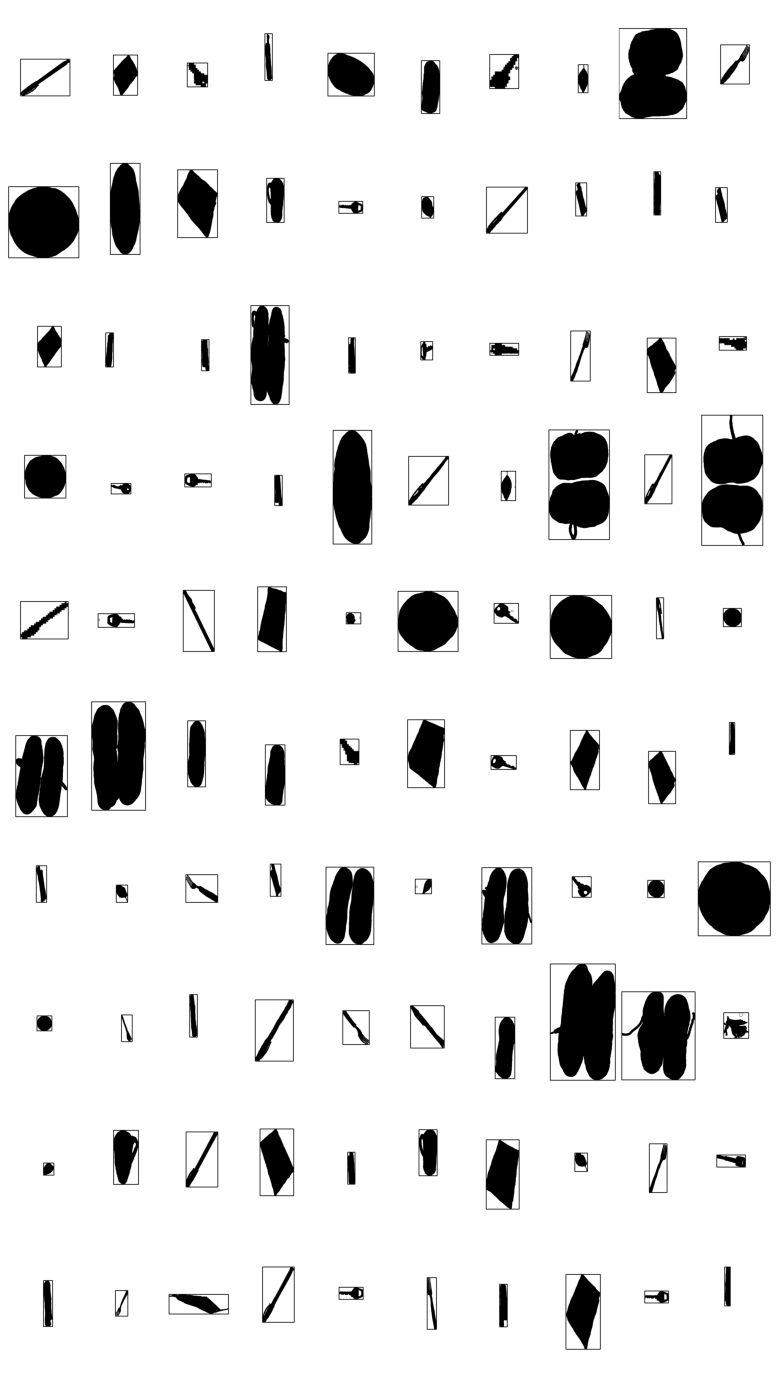

In [10]:
plot_feret_box(read_imgs('./dados/fotos_1280_720_groundtruth/','.png'))

## Plot Segmentação Automática - Output Notebook 3.1

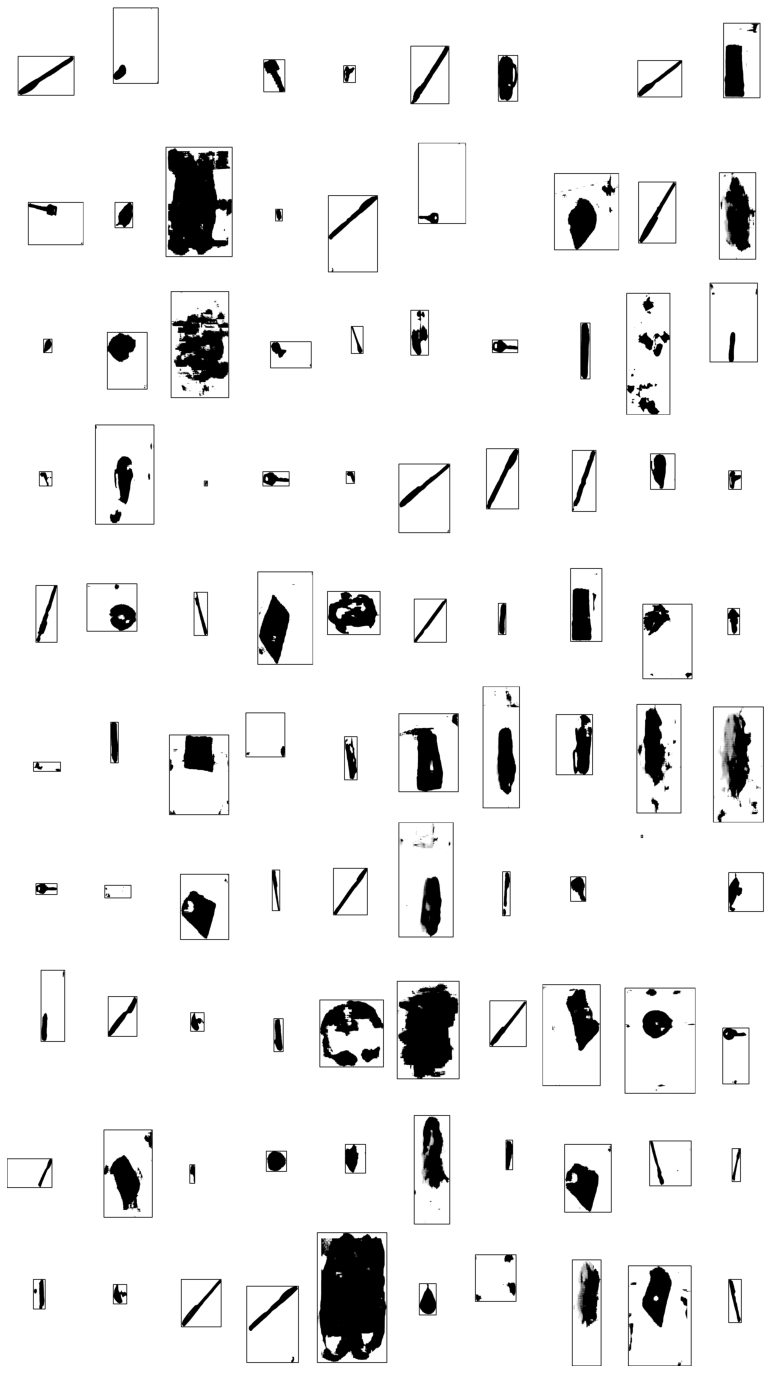

In [11]:
plot_feret_box(read_imgs('./dados/fotos_1280_720_autosegmentada/','.jpg'))

# Região de Interesse - ROI 

In [12]:
#Geração da Região de Interesse e salva na pasta "./dados/fotos_64_64_to_model"
get_roi(seg_manual=True,seg_auto=True)

## Plot Região de Interesse - Imagem 64 x 64

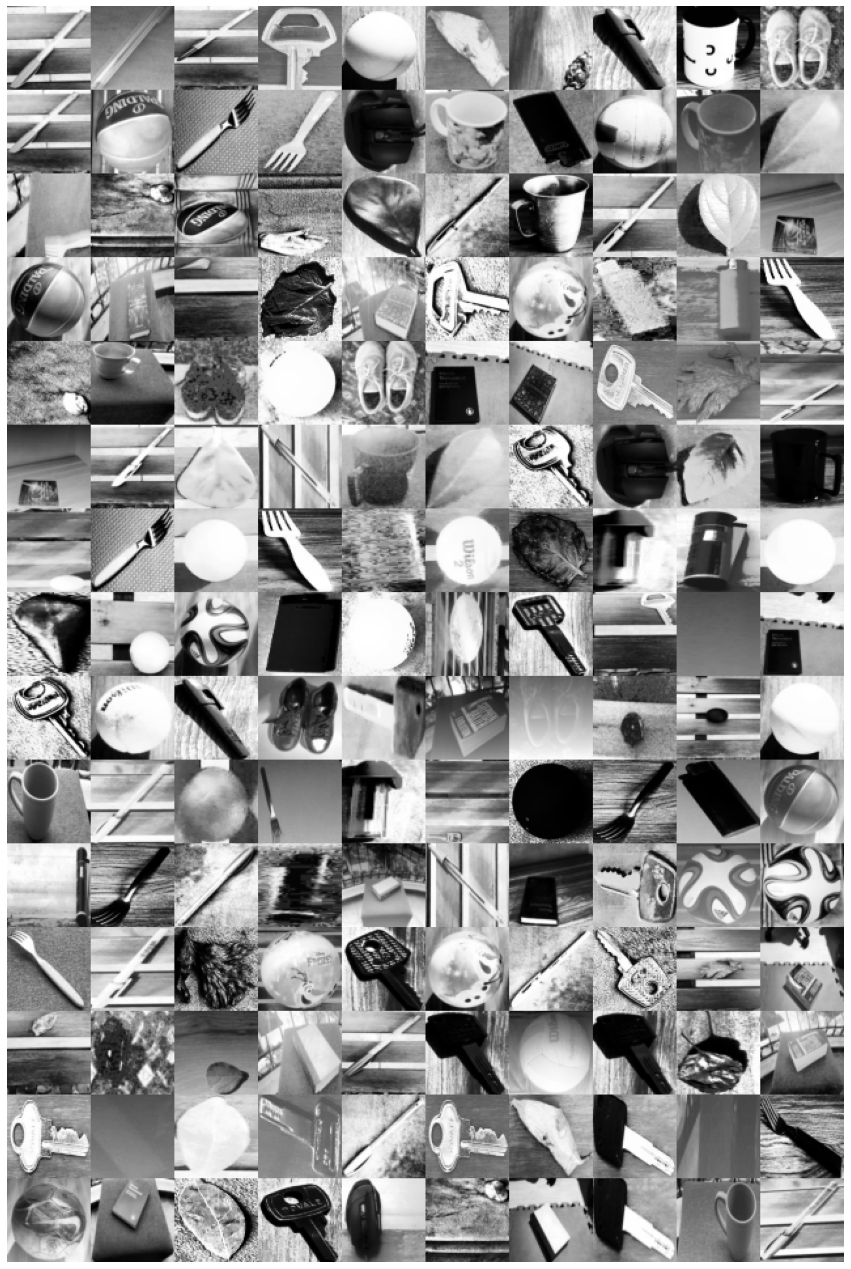

In [13]:
plot_data_to_model()

# Extrator de Características (PCA) e Aplicação Modelo (SVM)

In [14]:
all_imgs,all_targets = read_all_roi()

## Análise - Matriz de Confusão

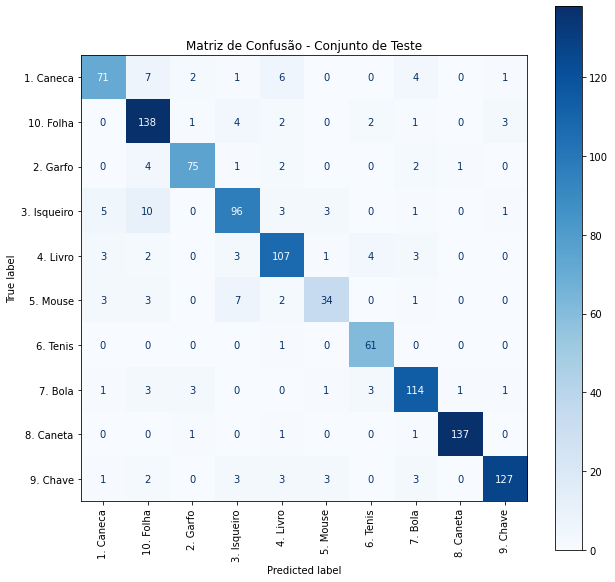

In [15]:
df = apply_pca_svm(all_imgs,all_targets, read_model = False)

## Relatório de Classificação - Conjunto de Teste

In [16]:
df

,precision,recall,f1-score,Quantidade
1. Caneca,0.845238,0.771739,0.806818,92
10. Folha,0.816568,0.913907,0.862500,151
2. Garfo,0.914634,0.882353,0.898204,85
3. Isqueiro,0.834783,0.806723,0.820513,119
4. Livro,0.842520,0.869919,0.856000,123
5. Mouse,0.809524,0.680000,0.739130,50
6. Tenis,0.871429,0.983871,0.924242,62
7. Bola,0.876923,0.897638,0.887160,127
8. Caneta,0.985612,0.978571,0.982079,140
9. Chave,0.954887,0.894366,0.923636,142
